Streaming output truncated to the last 5000 lines.
Agent 2, Episode 500, Reward: -785.5769164562225

Agent 2, Episode 501, Reward: -1637.4519592523575

Agent 2, Episode 502, Reward: -1648.3667095899582

Agent 2, Episode 503, Reward: -1122.602283000946

Agent 2, Episode 504, Reward: -1493.5973172187805

Agent 2, Episode 505, Reward: -1514.5584931373596

Agent 2, Episode 506, Reward: -1674.9197931289673

Agent 2, Episode 507, Reward: -1662.8453160226345

Agent 2, Episode 508, Reward: -1373.5011096000671

Agent 2, Episode 509, Reward: -1512.1541566848755

Agent 2, Episode 510, Reward: -1446.2600679397583

Agent 2, Episode 511, Reward: -1493.353928565979

Agent 2, Episode 512, Reward: -1383.721825838089

Agent 2, Episode 513, Reward: -1393.9755911827087

Agent 2, Episode 514, Reward: -1668.7028537988663

Agent 2, Episode 515, Reward: -1679.6523131132126

Agent 2, Episode 516, Reward: -1505.2124238014221

Agent 2, Episode 517, Reward: -1150.7553933858871

Agent 2, Episode 518, Reward: -1591

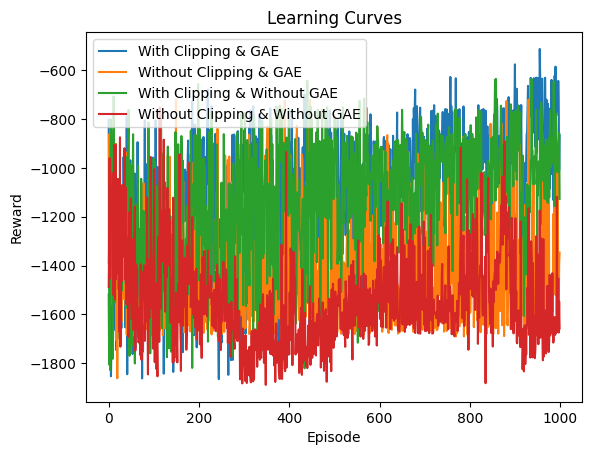

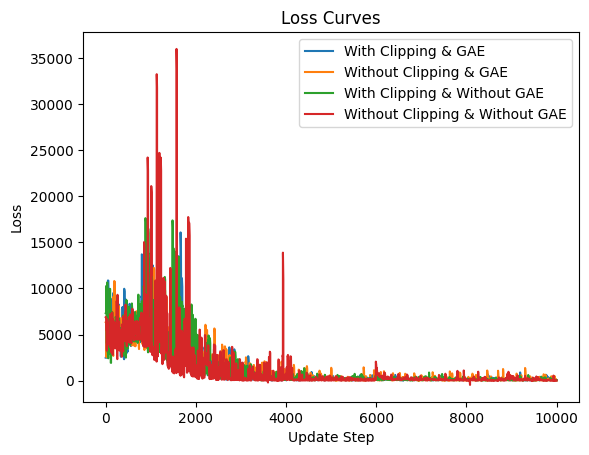

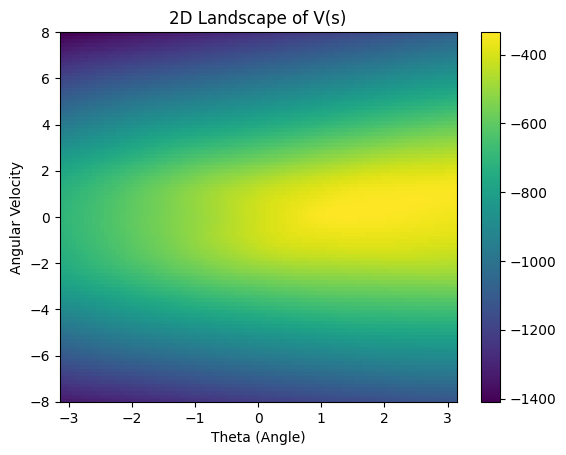

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import matplotlib.pyplot as plt


# Policy and Critic Networks
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.mu = nn.Linear(64, output_dim)
        self.log_std = nn.Parameter(torch.zeros(1, output_dim))

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        mu = self.mu(x)
        std = torch.exp(self.log_std)
        return mu, std

class CriticNetwork(nn.Module):
    def __init__(self, input_dim):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.value = nn.Linear(64, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        value = self.value(x)
        return value

# Replay Buffer
class ReplayBuffer:
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []
        self.values = []
        self.advantages = []

    def store(self, state, action, reward, log_prob, value):
        self.states.append(np.array(state, dtype=np.float32).reshape(-1))
        self.actions.append(np.array(action, dtype=np.float32).reshape(-1))
        self.rewards.append(float(reward))
        self.log_probs.append(log_prob.item())
        self.values.append(value.item())

    def compute_advantages(self, gamma, lam, next_value):
        returns = []
        advantages = []
        gae = 0

        for i in reversed(range(len(self.rewards))):
            delta = self.rewards[i] + gamma * next_value - self.values[i]
            gae = delta + gamma * lam * gae
            advantages.insert(0, gae)
            next_value = self.values[i]
            returns.insert(0, gae + self.values[i])

        self.advantages = advantages
        self.returns = returns

    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []
        self.values = []
        self.advantages = []

# PPO Agent
class PPOAgent:
    def __init__(self, state_dim, action_dim, lr=3e-4, gamma=0.99, lam=0.95, clip_ratio=0.2, epochs=10, use_clipping=True, use_gae=True):
        self.policy_net = PolicyNetwork(state_dim, action_dim).to(device)
        self.critic_net = CriticNetwork(state_dim).to(device)
        self.optimizer = optim.Adam(list(self.policy_net.parameters()) + list(self.critic_net.parameters()), lr=lr)
        self.gamma = gamma
        self.lam = lam
        self.clip_ratio = clip_ratio
        self.epochs = epochs
        self.buffer = ReplayBuffer()
        self.use_clipping = use_clipping
        self.use_gae = use_gae

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).to(device)
        mu, std = self.policy_net(state)
        dist = torch.distributions.Normal(mu, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum()
        value = self.critic_net(state)
        return action.cpu().detach().numpy(), log_prob.detach(), value.detach()

    def store_transition(self, state, action, reward, log_prob, value):
        self.buffer.store(state, action, reward, log_prob, value)

    def update(self, next_state):
        next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
        next_value = self.critic_net(next_state).detach()
        self.buffer.compute_advantages(self.gamma, self.lam, next_value)

        states = torch.tensor(np.array(self.buffer.states), dtype=torch.float32).to(device)
        actions = torch.tensor(np.array(self.buffer.actions), dtype=torch.float32).to(device)
        returns = torch.tensor(self.buffer.returns, dtype=torch.float32).to(device)
        advantages = torch.tensor(self.buffer.advantages, dtype=torch.float32).to(device)
        old_log_probs = torch.tensor(np.array(self.buffer.log_probs), dtype=torch.float32).to(device)

        loss_history = []
        for _ in range(self.epochs):
            mu, std = self.policy_net(states)
            dist = torch.distributions.Normal(mu, std)
            new_log_probs = dist.log_prob(actions).sum(dim=-1)
            ratio = torch.exp(new_log_probs - old_log_probs)

            if self.use_clipping:
                clipped_ratio = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio)
                surrogate_loss = torch.min(ratio * advantages, clipped_ratio * advantages)
            else:
                surrogate_loss = ratio * advantages

            policy_loss = -surrogate_loss.mean()
            values = self.critic_net(states).squeeze()
            value_loss = ((returns - values) ** 2).mean()
            loss = policy_loss + 0.5 * value_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            loss_history.append(loss.item())

        self.buffer.clear()
        return loss_history

# Training Function
def train(agents, num_episodes=1000, max_timesteps=200):
    env = gym.make('Pendulum-v1', new_step_api=True)
    all_rewards_history = []
    all_loss_history = []

    with open("reward_log.txt", "w") as f:
        for agent_idx, agent in enumerate(agents):
            rewards_history = []
            loss_history_total = []

            for episode in range(num_episodes):
                state = env.reset()
                state = np.array(state, dtype=np.float32).reshape(-1)
                episode_reward = 0

                for t in range(max_timesteps):
                    action, log_prob, value = agent.select_action(state.reshape(1, -1))
                    action = action.clip(env.action_space.low, env.action_space.high)

                    next_state, reward, terminated, truncated, _ = env.step(action)
                    done = terminated or truncated

                    reward = float(reward) if np.isscalar(reward) else reward.item()

                    agent.store_transition(state, action, reward, log_prob, value)
                    episode_reward += reward

                    if done or t == max_timesteps - 1:
                        loss_history = agent.update(next_state.reshape(1, -1))
                        loss_history_total.extend(loss_history)
                        break

                    state = np.array(next_state, dtype=np.float32).reshape(-1)

                rewards_history.append(episode_reward)
                log_entry = f"Agent {agent_idx + 1}, Episode {episode}, Reward: {episode_reward}\n"
                print(log_entry)
                f.write(log_entry)

            all_rewards_history.append(rewards_history)
            all_loss_history.append(loss_history_total)

    return all_rewards_history, all_loss_history

# Plotting Function
def plot_learning_curves(rewards_history_list, labels):
    for rewards_history, label in zip(rewards_history_list, labels):
        plt.plot(rewards_history, label=label)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Learning Curves')
    plt.legend()
    plt.savefig('learning_curve.png')
    plt.show()

def plot_loss_curves(loss_history_list, labels):
    for loss_history, label in zip(loss_history_list, labels):
        plt.plot(loss_history, label=label)
    plt.xlabel('Update Step')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.savefig('loss_curve.png')
    plt.show()

# Training Agents with Different Configurations
agent1 = PPOAgent(state_dim=3, action_dim=1, use_clipping=True, use_gae=True)   # With Clipping and GAE
agent2 = PPOAgent(state_dim=3, action_dim=1, use_clipping=False, use_gae=True)  # Without Clipping, with GAE
agent3 = PPOAgent(state_dim=3, action_dim=1, use_clipping=True, use_gae=False)  # With Clipping, without GAE
agent4 = PPOAgent(state_dim=3, action_dim=1, use_clipping=False, use_gae=False) # Without Clipping, without GAE

agents = [agent1, agent2, agent3, agent4]
labels = [
    "With Clipping & GAE",
    "Without Clipping & GAE",
    "With Clipping & Without GAE",
    "Without Clipping & Without GAE"
]

# Train the agents and plot the results
all_rewards_history, all_loss_history = train(agents)
plot_learning_curves(all_rewards_history, labels)
plot_loss_curves(all_loss_history, labels)

# Visualization of V(s) Landscape (Run this after training)
def visualize_value_landscape(agent):
    theta_range = np.linspace(-np.pi, np.pi, 100)
    theta_dot_range = np.linspace(-8, 8, 100)
    theta, theta_dot = np.meshgrid(theta_range, theta_dot_range)

    V = np.zeros_like(theta)

    for i in range(theta.shape[0]):
        for j in range(theta.shape[1]):
            state = np.array([theta[i, j], theta_dot[i, j], 0.0], dtype=np.float32).reshape(1, -1)
            state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
            V[i, j] = agent.critic_net(state_tensor).item()

    plt.imshow(V, extent=[-np.pi, np.pi, -8, 8], origin='lower', aspect='auto')
    plt.colorbar()
    plt.xlabel('Theta (Angle)')
    plt.ylabel('Angular Velocity')
    plt.title('2D Landscape of V(s)')
    plt.savefig('value_landscape.png')
    plt.show()

visualize_value_landscape(agent1)
